In [1]:
import pandas as pd
import numpy as np

import os
import sys
from sys import argv
import pickle
import random
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statistics
import math

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, f1_score
import sklearn

In [2]:
classification_datasets = ["diabetes", "breast_cancer", "income"]
regression_datasets = ["housing", "student_scores", "bike_sharing"]
datasets = []
datasets.extend(classification_datasets)
datasets.extend(regression_datasets)

models = ["decision_tree", "xgboost"]

data_names = {"breast_cancer":"Breast Cancer", "diabetes":"Diabetes", "income": "Adult Income",
             "housing": "House Prices", "student_scores": "Student Scores", "bike_sharing": "Bike Rentals"}

PATH = os.getcwd()

# Check Model Accuracy

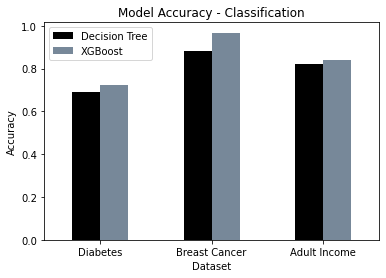

In [3]:
dt_train_acc = []
dt_test_acc = []
xgb_train_acc = []
xgb_test_acc = []

for data in classification_datasets:
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";").values
    X_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtest.csv"), sep = ";").values
    X_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xvalidation.csv"), sep = ";").values
    test_x = np.vstack([X_test, X_validation])
    
    y_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytrain.csv"), sep = ";").values
    y_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytest.csv"), sep = ";").values
    y_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Yvalidation.csv"), sep = ";").values
    test_y = np.vstack([y_test, y_validation])
    
    for classifier in models:
        cls = joblib.load(os.path.join(PATH, data, classifier, "cls.joblib"))
        train_acc = f1_score(y_train, cls.predict(X_train))
        test_acc = f1_score(test_y, cls.predict(test_x))
        if classifier == "decision_tree":
            dt_train_acc.append(train_acc)
            dt_test_acc.append(test_acc)
        else:
            xgb_train_acc.append(train_acc)
            xgb_test_acc.append(test_acc)


df_acc = pd.DataFrame(np.c_[dt_test_acc, xgb_test_acc], index=[data_names[data] for data in classification_datasets],
                  columns = ["Decision Tree", "XGBoost"])
df_acc.plot.bar(color={"Decision Tree": "black", "XGBoost": "#778899"})
plt.xticks(rotation = 0)
plt.title("Model Accuracy - Classification")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
#plt.savefig(final_folder+dataset+"_"+cls_method+"_"+bin_type+".eps")
plt.show()

In [4]:
df_acc

,Decision Tree,XGBoost
Diabetes,0.690058,0.721519
Breast Cancer,0.883333,0.967213
Adult Income,0.822509,0.840449


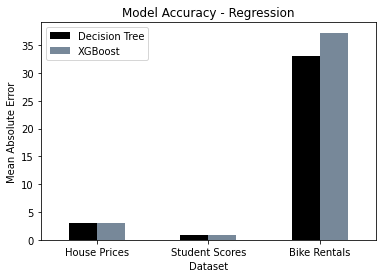

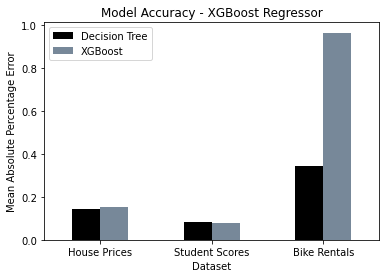

In [5]:
dt_train_mae = []
dt_test_mae = []
dt_train_mape = []
dt_test_mape = []

xgb_train_mae = []
xgb_test_mae = []
xgb_train_mape = []
xgb_test_mape = []

for data in regression_datasets:
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";").values
    X_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtest.csv"), sep = ";").values
    X_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xvalidation.csv"), sep = ";").values
    test_x = np.vstack([X_test, X_validation])
    
    y_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytrain.csv"), sep = ";").values
    y_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Ytest.csv"), sep = ";").values
    y_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Yvalidation.csv"), sep = ";").values
    test_y = np.vstack([y_test, y_validation])
    
    for model in models:
        cls = joblib.load(os.path.join(PATH, data, model, "cls.joblib"))
        train_mae = mean_absolute_error(y_train, cls.predict(X_train))
        test_mae = mean_absolute_error(test_y, cls.predict(test_x))
        train_mape = mean_absolute_percentage_error(y_train, cls.predict(X_train))
        test_mape = mean_absolute_percentage_error(test_y, cls.predict(test_x))
        if model == "decision_tree":
            dt_train_mae.append(train_mae)
            dt_test_mae.append(test_mae)
            dt_train_mape.append(train_mape)
            dt_test_mape.append(test_mape)
        else:
            xgb_train_mae.append(train_mae)
            xgb_test_mae.append(test_mae)
            xgb_train_mape.append(train_mape)
            xgb_test_mape.append(test_mape)
            
df_mae = pd.DataFrame(np.c_[dt_test_mae, xgb_test_mae], index=[data_names[data] for data in regression_datasets], 
                  columns = ["Decision Tree", "XGBoost"])
df_mae.plot.bar(color={"Decision Tree": "black", "XGBoost": "#778899"})
plt.xticks(rotation = 0)
plt.title("Model Accuracy - Regression")
plt.xlabel("Dataset")
plt.ylabel("Mean Absolute Error")
plt.show()

df_mape = pd.DataFrame(np.c_[dt_test_mape, xgb_test_mape], index=[data_names[data] for data in regression_datasets],
                  columns = ["Decision Tree", "XGBoost"])
df_mape.plot.bar(color={"Decision Tree": "black", "XGBoost": "#778899"})
plt.xticks(rotation = 0)
plt.title("Model Accuracy - XGBoost Regressor")
plt.xlabel("Dataset")
plt.ylabel("Mean Absolute Percentage Error")
plt.show()

# Generate Model Architecture Stats

In [6]:
def get_tree_characteristics(tree, feat_list, cur_depth = 0, lvl = 0, depths = [], split_nodes = [], leaf_nodes = []):

    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]
    
    if left_child == sklearn.tree._tree.TREE_LEAF:
        depths.append(cur_depth)
        leaf_nodes.append(lvl)
        
    else:
        split_nodes.append(lvl)
        depths, split_nodes, leaf_nodes = get_tree_characteristics(tree, feat_list, cur_depth+1, left_child, depths, split_nodes, leaf_nodes)
        depths, split_noes, leaf_nodes = get_tree_characteristics(tree, feat_list, cur_depth+1, right_child, depths, split_nodes, leaf_nodes)
        
    return depths, split_nodes, leaf_nodes

In [7]:
print("Decision Tree Characteristics")

for data in datasets:
    split_nodes = []
    leaf_nodes = []
    
    cls = joblib.load(os.path.join(PATH, data, "decision_tree", "cls.joblib"))
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";")
    depths, split_nodes, leaf_nodes = get_tree_characteristics(cls.tree_, X_train.columns, split_nodes = split_nodes, leaf_nodes = leaf_nodes)
    
    max_depth = max(depths)
    splits = len(split_nodes)
    leaves = len(leaf_nodes)
    
    print(data_names[data], "\t", max_depth, "\t", splits, "\t", leaves)

Decision Tree Characteristics
Diabetes 	 5 	 8 	 9
Breast Cancer 	 5 	 6 	 7
Adult Income 	 17 	 54 	 55
House Prices 	 19 	 343 	 344
Student Scores 	 19 	 24 	 25
Bike Rentals 	 28 	 3515 	 3516


In [8]:
print("XGBoost Characteristics")

for data in datasets:
    split_nodes = []
    leaf_nodes = []
    
    cls = joblib.load(os.path.join(PATH, data, "xgboost", "cls.joblib"))
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";")
    dump_list = cls.get_booster().get_dump()
    num_trees = len(dump_list)
    
    full_tree = cls._Booster.trees_to_dataframe()
    leaves = full_tree[full_tree['Feature']=='Leaf']
    splits = full_tree[full_tree['Feature']!='Leaf']
    
    num_leaves = len(leaves)
    num_splits = len(splits)
    
    print(data_names[data], "\t", num_trees, "\t", num_splits, "\t", num_leaves)

XGBoost Characteristics
Diabetes 	 100 	 4767 	 4867
Breast Cancer 	 100 	 1178 	 1278
Adult Income 	 100 	 100 	 200
House Prices 	 100 	 100 	 200
Student Scores 	 100 	 100 	 200
Bike Rentals 	 100 	 10540 	 10640


# Generate Dataset Stats

In [9]:
print("Dataset \t num_feat \t train_len \t test_len")
for data in datasets:
    X_train = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtrain.csv"), sep = ";")
    X_test = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xtest.csv"), sep = ";").values
    X_validation = pd.read_csv(os.path.join(PATH, data, "datasets", data+"_Xvalidation.csv"), sep = ";").values
    test_x = np.vstack([X_test, X_validation])
    
    print(data_names[data], "\t", len(X_train.columns), "\t\t", len(X_train), "\t\t", len(test_x))

Dataset 	 num_feat 	 train_len 	 test_len
Diabetes 	 8 		 375 		 161
Breast Cancer 	 30 		 296 		 128
Adult Income 	 104 		 10977 		 4705
House Prices 	 13 		 354 		 152
Student Scores 	 58 		 454 		 195
Bike Rentals 	 12 		 12165 		 5214


# Model Visualisation (DT only)

In [10]:
from sklearn import tree
import pydotplus

dataset = "diabetes"

cls = joblib.load(os.path.join(PATH, dataset, "decision_tree", "cls.joblib"))
X_train = pd.read_csv(os.path.join(PATH, dataset, "datasets", dataset+"_Xtrain.csv"), sep = ";")

class_names = ["Negative", "Positive"]

dot_data = tree.export_graphviz(cls, out_file=None, feature_names=X_train.columns, class_names=class_names,
                                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

samples = X_train.values[:1]
decision_paths = cls.decision_path(samples)

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        node = graph.get_node(str(n))[0]            
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)

        node.set('label', '<br/>'.join(labels))